In [1]:
print("all ok!")

all ok!


In [3]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
import random

In [22]:
load_dotenv()

True

In [10]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper=GoogleSerperAPIWrapper()

serper.run("what is capital of Pakistan")

'Islamabad'

## Custom ***Tool***

In [11]:
from langchain.agents import Tool # this langchain class coverts functions into tools

search_tool=Tool(
    name="search",
    func=serper.run,
    description="Useful for when you need to more information from online search"
)

In [12]:
search_tool.invoke("waht is capital of Pkaistan")

'Islamabad'

In [25]:
import os
import requests

PUSHOVER_URL="https://api.pushover.net/1/messages.json"
PUSHOVER_USER=os.getenv("PUSHOVER_USER")
PUSHOVER_TOKEN=os.getenv("PUSHOVER_TOKEN")

def push(text: str):
    """Send a push notification to the user"""
    requests.post(PUSHOVER_URL, data={"token":PUSHOVER_TOKEN, "user":PUSHOVER_USER, "message":text})

In [27]:
push_tool=Tool(
    name="send_push_notifications",
    func=push,
    description="Useful for when you need to send a push notification"
)

In [28]:
push_tool.invoke("Hi Sir!")

In [29]:
tools=[search_tool, push_tool]

## Creating a ***Graph***

In [30]:
# Defining a state

class State(TypedDict):
    messages: Annotated[list, add_messages]

In [ ]:
graph_builder=StateGraph(State)

In [34]:
llm=ChatOpenAI(model="gpt-4o-mini")
llm_with_tools=llm.bind_tools(tools)

In [36]:
# creating a Node

def chatbot(state: State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

In [37]:
# Creating Edges

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")

In [38]:
graph=graph_builder.compile()

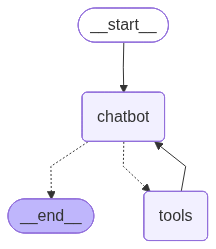

In [39]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [40]:
def chat(user_input: str, history):
    result=graph.invoke({"messages":[{"role":"user", "content":user_input}]})
    print(result)
    return result["messages"][-1].content

In [41]:
gr.ChatInterface(chat, type="messages").launch(share=False, debug=True)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='How are you?', additional_kwargs={}, response_metadata={}, id='100e9a25-ce09-4ef9-99e9-24404c19d40f'), AIMessage(content="I'm just a computer program, so I don't have feelings, but I'm here and ready to assist you! How can I help you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 92, 'total_tokens': 121, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CNGqojvj3enZKS9iiMaB9GG0AeA1G', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--d8075837-9c10-4889-a385-d6766ec5a694-0', usage_metadata={'input_tokens': 92, 'output_tokens': 29, 'total_tokens': 121, 'input_token_details': {'audio': 0, 'cache_read': 

## Adding ***Memory*** to the State

In [43]:
from langgraph.checkpoint.memory import MemorySaver

memory=MemorySaver()

In [44]:
graph_builder=StateGraph(State)

In [45]:
llm=ChatOpenAI(model="gpt-4o-mini")
llm_with_tools=llm.bind_tools(tools)

# creating a Node

def chatbot(state: State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Creating Edges

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")

graph=graph_builder.compile(checkpointer=memory)

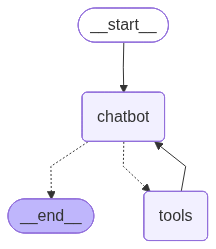

In [46]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [47]:
config={"configurable":{"thread_id":"1"}}

def chat(user_input: str, history):
    result=graph.invoke({"messages":[{"role":"user", "content":user_input}]}, config=config)
    print(result)
    return result["messages"][-1].content

In [48]:
gr.ChatInterface(chat, type="messages").launch(share=False, debug=True)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='My name is Asif', additional_kwargs={}, response_metadata={}, id='4ba79338-5a06-4a97-a411-a9e8e0ee5536'), AIMessage(content='Hello Asif! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 93, 'total_tokens': 105, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CNHXY9huY9ynSnwiZCYAgeF87zKoD', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--1176d315-d8ef-4d73-bdee-76f104cc61a3-0', usage_metadata={'input_tokens': 93, 'output_tokens': 12, 'total_tokens': 105, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}
{'messages': [H

In [49]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='My name is Asif', additional_kwargs={}, response_metadata={}, id='4ba79338-5a06-4a97-a411-a9e8e0ee5536'), AIMessage(content='Hello Asif! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 93, 'total_tokens': 105, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CNHXY9huY9ynSnwiZCYAgeF87zKoD', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--1176d315-d8ef-4d73-bdee-76f104cc61a3-0', usage_metadata={'input_tokens': 93, 'output_tokens': 12, 'total_tokens': 105, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0

In [51]:
list(graph.get_state_history(config))

[StateSnapshot(values={'messages': [HumanMessage(content='My name is Asif', additional_kwargs={}, response_metadata={}, id='4ba79338-5a06-4a97-a411-a9e8e0ee5536'), AIMessage(content='Hello Asif! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 93, 'total_tokens': 105, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CNHXY9huY9ynSnwiZCYAgeF87zKoD', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--1176d315-d8ef-4d73-bdee-76f104cc61a3-0', usage_metadata={'input_tokens': 93, 'output_tokens': 12, 'total_tokens': 105, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 

## Buildin Persistent AI Memory with SQLite

In [55]:
!pip install langgraph-checkpoint-sqlite

  Using cached langgraph_checkpoint_sqlite-2.0.11-py3-none-any.whl.metadata (2.6 kB)
  Using cached aiosqlite-0.21.0-py3-none-any.whl.metadata (4.3 kB)
  Using cached sqlite_vec-0.1.6-py3-none-win_amd64.whl.metadata (198 bytes)
Using cached langgraph_checkpoint_sqlite-2.0.11-py3-none-any.whl (31 kB)
Using cached aiosqlite-0.21.0-py3-none-any.whl (15 kB)
Using cached sqlite_vec-0.1.6-py3-none-win_amd64.whl (281 kB)


In [56]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

# Test the import
print("SqliteSaver imported successfully!")
print(f"SqliteSaver class: {SqliteSaver}")

SqliteSaver imported successfully!
SqliteSaver class: <class 'langgraph.checkpoint.sqlite.SqliteSaver'>


In [57]:

db_path="memory.db"

conn=sqlite3.connect(db_path, check_same_thread=False)
sql_memory=SqliteSaver(conn)

In [60]:
graph_builder=StateGraph(State)

llm=ChatOpenAI(model="gpt-4o-mini")
llm_with_tools=llm.bind_tools(tools)

# creating a Node

def chatbot(state: State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Creating Edges

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")

graph=graph_builder.compile(checkpointer=sql_memory)

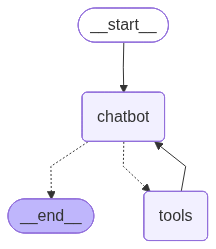

In [61]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [62]:
config={"configurable":{"thread_id":"3"}}

def chat(user_input: str, history):
    result=graph.invoke({"messages":[{"role":"user", "content":user_input}]}, config=config)
    print(result)
    return result["messages"][-1].content

In [64]:
gr.ChatInterface(chat, type="messages").launch(share=False, debug=True)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='my name is Asif', additional_kwargs={}, response_metadata={}, id='07c4c54a-3d44-4c0f-8835-0da391fa5a96'), AIMessage(content='Nice to meet you, Asif! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 93, 'total_tokens': 109, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CNI4ePPIKmil5FX7qkX5LfQ60DWmL', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--8c6e9834-11d4-490a-9e12-9637d4dcf918-0', usage_metadata={'input_tokens': 93, 'output_tokens': 16, 'total_tokens': 109, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), Huma

In [65]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='my name is Asif', additional_kwargs={}, response_metadata={}, id='07c4c54a-3d44-4c0f-8835-0da391fa5a96'), AIMessage(content='Nice to meet you, Asif! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 93, 'total_tokens': 109, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CNI4ePPIKmil5FX7qkX5LfQ60DWmL', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--8c6e9834-11d4-490a-9e12-9637d4dcf918-0', usage_metadata={'input_tokens': 93, 'output_tokens': 16, 'total_tokens': 109, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'r

In [66]:
list(graph.get_state_history(config))

[StateSnapshot(values={'messages': [HumanMessage(content='my name is Asif', additional_kwargs={}, response_metadata={}, id='07c4c54a-3d44-4c0f-8835-0da391fa5a96'), AIMessage(content='Nice to meet you, Asif! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 93, 'total_tokens': 109, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CNI4ePPIKmil5FX7qkX5LfQ60DWmL', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--8c6e9834-11d4-490a-9e12-9637d4dcf918-0', usage_metadata={'input_tokens': 93, 'output_tokens': 16, 'total_tokens': 109, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, '